# Notebook 5: Everest Expedition EDA & Modeling

Capstone Project, Nadia W. Morgen

## Data & Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import meanabs

import time

import pickle

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


In [2]:
everest_posted = pd.read_csv('data/everest_posted.csv')

In [3]:
everest_posted.dtypes

date         object
datetime     object
SACTMIN     float64
SPOSTMIN    float64
weekday       int64
day_name     object
dtype: object

In [4]:
everest_posted.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
0,2015-01-01,2015-01-01 07:47:26,NaN,5.0,4,Thursday
1,2015-01-01,2015-01-01 07:54:23,NaN,5.0,4,Thursday
2,2015-01-01,2015-01-01 08:05:33,NaN,5.0,4,Thursday
3,2015-01-01,2015-01-01 08:12:23,NaN,5.0,4,Thursday
4,2015-01-01,2015-01-01 08:19:26,NaN,5.0,4,Thursday


I have to reconvert the fields into my desired datatypes and reestablish date as the index.

In [5]:
everest_posted['date'] = pd.to_datetime(everest_posted['date'])
everest_posted['datetime'] = pd.to_datetime(everest_posted['datetime'])

# Add column for day of the week
everest_posted['weekday'] = everest_posted['date'].dt.dayofweek

# Adjust index so Monday == 1
everest_posted['weekday'] = everest_posted['weekday'] + 1

everest_posted['day_name'] = everest_posted['date'].dt.day_name()
everest_posted['day_name'] = everest_posted.day_name.astype('string')

# Also creating two dataframes, one indexed on date, the other indexed on datetime
# This makes future computations much easier
everest_date = everest_posted.copy()
everest_date.set_index('date', inplace=True)


everest_dt = everest_posted.copy()
everest_dt.set_index('datetime', inplace = True)


# Breakup up data into precovid and covid-era
# precovid_daily includes wait times with daily means
precovid_daily = everest_posted.copy()
precovid_daily['date2'] = precovid_daily['date']

covid = everest_posted.copy()
covid['date2'] = covid['date']
covid = covid[covid['date'] > '2019-07-15']

# precovid includes all rows for each day during covid
# each day has roughly 1 row for every 7 min the ride was open
precovid = everest_posted.copy()
precovid = precovid[precovid['date'] < '2020-01-01']

everest_posted.set_index('date', inplace = True)

# EDA - Everest Expedition

## Overview

As with the other rides, the data are imperfect.  There are days when there are multiple values recorded and days where there are none.  We see the most missing data in 2020 and 2021.  A large chunk of that was due to park closures due to COVID.  However, this doesn't explain the gap between Jan, 2021 and July, 2021.

### Wait Times Since Ride Opened

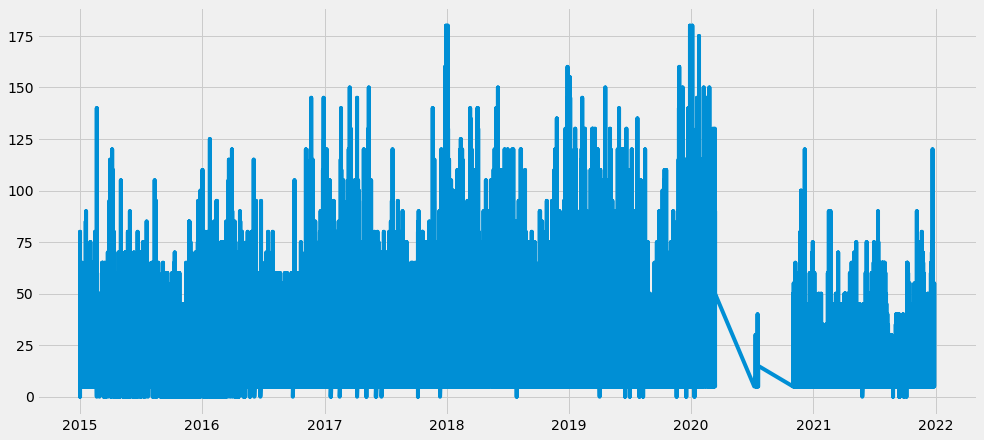

In [6]:
# Plot all wait times
plt.figure(figsize = (15, 7))
plt.plot(everest_posted['SPOSTMIN']);

In [7]:
everest_posted.tail(50)

,datetime,SACTMIN,SPOSTMIN,weekday,day_name
date,,,,,
2021-12-28,2021-12-28 15:06:04,NaN,45.0,2,Tuesday
2021-12-28,2021-12-28 15:11:30,NaN,40.0,2,Tuesday
2021-12-28,2021-12-28 15:15:24,NaN,40.0,2,Tuesday
2021-12-28,2021-12-28 15:20:56,NaN,40.0,2,Tuesday
2021-12-28,2021-12-28 15:27:23,NaN,40.0,2,Tuesday
2021-12-28,2021-12-28 15:35:19,NaN,40.0,2,Tuesday
2021-12-28,2021-12-28 15:40:36,NaN,35.0,2,Tuesday
2021-12-28,2021-12-28 15:45:31,NaN,35.0,2,Tuesday
2021-12-28,2021-12-28 15:52:31,NaN,30.0,2,Tuesday


In [8]:
print(f"Minimum Wait: {everest_posted['SPOSTMIN'].min()}")
print(f"Maximum Wait: {everest_posted['SPOSTMIN'].max()}")

Minimum Wait: 0.0
Maximum Wait: 180.0


Because of missing data and the covid closure (March 15 - July 11, 2020), I'm separating the precovid data from the covid data.  Because covid began affecting tourism prior to Disney's official closure, "precovid" is defined as prior to January 1, 2019.

In [9]:
precovid_daily.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2
0,2015-01-01,2015-01-01 07:47:26,NaN,5.0,4,Thursday,2015-01-01
1,2015-01-01,2015-01-01 07:54:23,NaN,5.0,4,Thursday,2015-01-01
2,2015-01-01,2015-01-01 08:05:33,NaN,5.0,4,Thursday,2015-01-01
3,2015-01-01,2015-01-01 08:12:23,NaN,5.0,4,Thursday,2015-01-01
4,2015-01-01,2015-01-01 08:19:26,NaN,5.0,4,Thursday,2015-01-01


In [10]:
# Limit data to precovid
precovid_daily = precovid_daily[precovid_daily.date2 < '2019-01-01']
precovid_daily.set_index('date', inplace=True)

# Group waiting times by date to get avg_daily_wait
precovid_daily['avg_daily_wait'] = precovid_daily.groupby('date2')['SPOSTMIN'].mean()
precovid_daily = precovid_daily.drop_duplicates(subset='date2', keep='last')
precovid_daily.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2015-01-01,2015-01-01 18:54:23,NaN,20.0,4,Thursday,2015-01-01,40.268817
2015-01-02,2015-01-02 19:54:22,NaN,5.0,5,Friday,2015-01-02,34.198113
2015-01-03,2015-01-03 18:54:22,NaN,15.0,6,Saturday,2015-01-03,29.793814
2015-01-04,2015-01-04 19:54:27,NaN,5.0,7,Sunday,2015-01-04,23.850000
2015-01-05,2015-01-05 16:54:24,NaN,10.0,1,Monday,2015-01-05,26.956522


In [11]:
# Perform same operations on covid data for testing
covid.set_index('date', inplace=True)

# Group waiting times by date to get avg_daily_posted_wait
covid['avg_daily_wait'] = covid.groupby('date2')['SPOSTMIN'].mean()
covid = covid.drop_duplicates(subset='date2', keep='last')
covid.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2019-07-16,2019-07-16 20:59:01,NaN,5.0,2,Tuesday,2019-07-16,49.950000
2019-07-17,2019-07-17 20:59:02,NaN,5.0,3,Wednesday,2019-07-17,39.333333
2019-07-18,2019-07-18 23:59:01,NaN,15.0,4,Thursday,2019-07-18,44.425287
2019-07-19,2019-07-19 21:59:02,NaN,10.0,5,Friday,2019-07-19,39.574468
2019-07-20,2019-07-20 21:59:02,NaN,10.0,6,Saturday,2019-07-20,38.518519


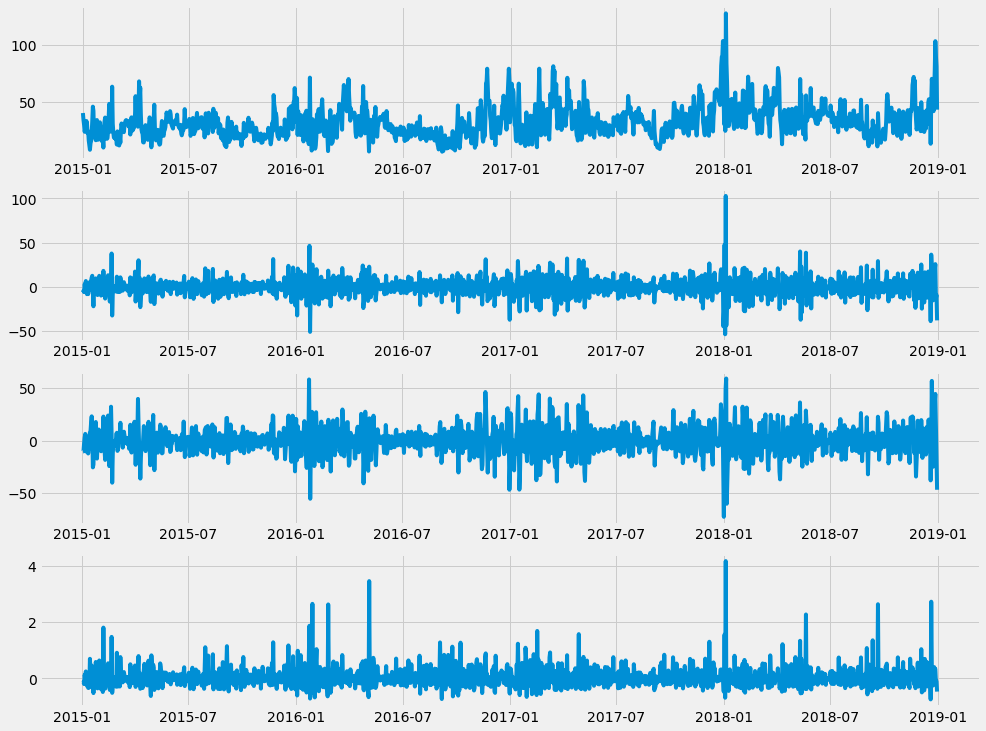

In [12]:
fig, axes = plt.subplots(nrows = 4, figsize = (15, 12))
axes[0].plot(precovid_daily['avg_daily_wait'])
axes[1].plot(precovid_daily['avg_daily_wait'].diff())
axes[2].plot(precovid_daily['avg_daily_wait'].diff(2))
axes[3].plot(precovid_daily['avg_daily_wait'].pct_change());

Top plot: Daily mean wait time
2nd plot: Daily mean wait time differenced once
3rd plot: Daily mean wait time differenced twice
4th plot: Percent change of daily mean wait time

There are no clear indications of seasonality.  Although there are spikes in Dec, 2017 and Dec, 2018, the same spikes are not seen in previous years.

I will conduct Adfuller and decomposition analysis in the modeling section to verify that there is no seasonality, but at this point it appears that there is fluctuation, but not seasonality.

### Covid vs. Precovid

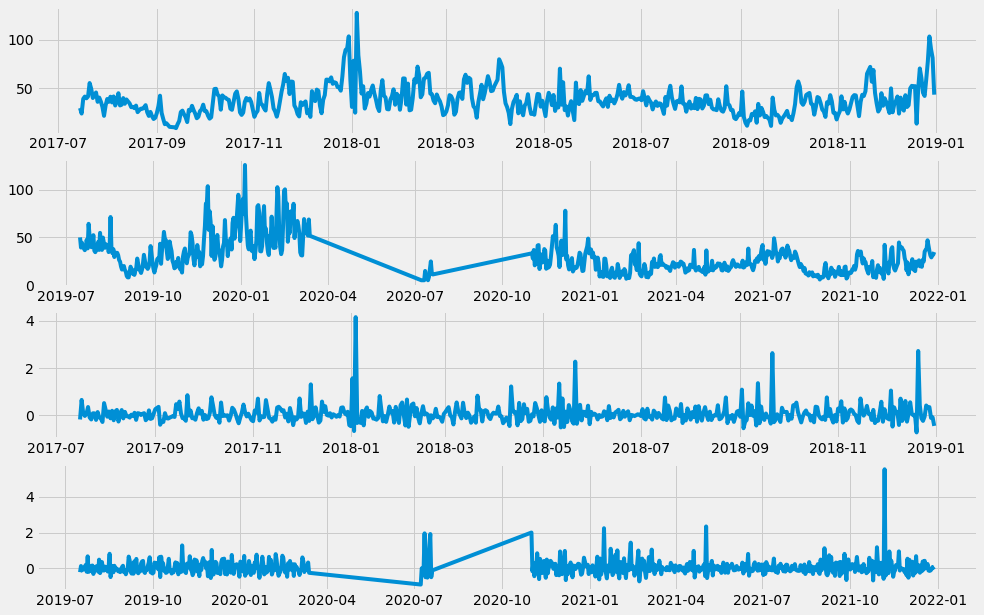

In [13]:
# to facilitate comparison, I'm starting both datasets at the same month for these plots.

precovid_daily_July = precovid_daily[precovid_daily['date2'] > '2017-07-14']

fig, axes = plt.subplots(nrows = 4, figsize = (15, 10))
axes[0].plot(precovid_daily_July['avg_daily_wait'])
axes[1].plot(covid['avg_daily_wait'])
axes[2].plot(precovid_daily_July['avg_daily_wait'].pct_change())
axes[3].plot(covid['avg_daily_wait'].pct_change());

## Day of the Week Seasonality

I would expect longer wait times on weekends, when locals and especially annual passholders are most likely to visit the park.  This is likely to have changed during covid after annual pass rules changed in 2021.

In 2021, Disney overhauled their annual passholder program.  In addition to steep price hikes, they require reservations for annual pass holders to ensure they won't exceed their lower park capacity (anywhere from  25%-50% of regular capacity, depending on the timing of the visit and the pandemic).  Reservations do not cost extra, but lower level passholders have limits on the number of reservations they can make each month; they also have additional blockout dates they never had before.

In [14]:
# Check for Seasonality Based on Day of the week
# Calculate average daily wait based on day of the week (all Mondays, etc.)

av_wait_by_day_of_week = precovid_daily.groupby('day_name')['avg_daily_wait'].mean()
av_wait_by_day_of_week

day_name
Friday       33.952877
Monday       32.826487
Saturday     36.289903
Sunday       34.864901
Thursday     31.139313
Tuesday      29.794101
Wednesday    27.632620
Name: avg_daily_wait, dtype: float64

Before covid, wait times by day of the the differed by 9 minutes.  Saturdays were longest; Wednesdays were shortest.

In [15]:
# Covid-era seasonality based on day of the week
av_wait_by_day_of_week = covid.groupby('day_name')['avg_daily_wait'].mean()
av_wait_by_day_of_week

day_name
Friday       28.577968
Monday       29.247681
Saturday     34.062591
Sunday       33.807863
Thursday     26.031036
Tuesday      29.148611
Wednesday    24.827861
Name: avg_daily_wait, dtype: float64

In [64]:
26.03 / 31.14

0.8359023763648041

During covid, Wednesdays still have the shortest wait and Saturdays have the longest.  They differ by 10 minutes, with wait times dropping a few minutes overall.  The largest average drop was 5 minutes on Thursdays, a 17% difference.

Is this 17% difference QUALITATIVELY different, meaning does it change guests' behavior (whether or not to get in line, buy a Lightning Lane pass, etc.)?  I cannot know without having actual Disney data.  The question boils down to whether guests have a threshold of how long they're willing to wait and how much they're willing to pay.  Local passholders are likely more willing to wait or choose other rides if they don't like wait times, unless the ride is new or always has long wait times.  Long-distance travelers spending thousands of dollars are more likely to pay to skip lines.  The question is where the threshold lies.

## Hourly Seasonality

Is there a time of day when the ride has significantly shorter or longer wait times?  I'll examine data for a Wednesday (when the average wait was shortest) and a Saturday (when average wait was longest) and look for hourly trends.

In [16]:
# Step 1: Filter data for one day
# This was the Wednesday after Thanksgiving, 2018

everest_Wed_Dec_05 = precovid[precovid['date'] == '2018-12-5']
everest_Wed_Dec_05.set_index('datetime', inplace = True)

In [17]:
print(f"Minimum wait: {everest_Wed_Dec_05['SPOSTMIN'].min()}")
print(f"Maximum wait: {everest_Wed_Dec_05['SPOSTMIN'].max()}")

Minimum wait: 5.0
Maximum wait: 45.0


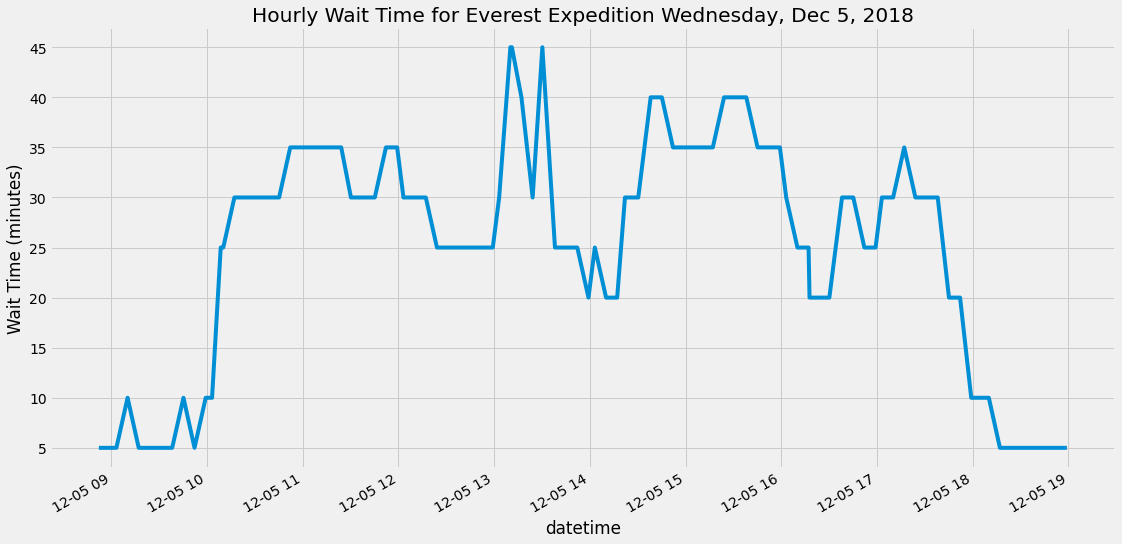

In [65]:
# Step 2: Plot hourly data for Wednesday, Dec 5, 2018

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Everest Expedition Wednesday, Dec 5, 2018")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')

# Set title and labels for axes

everest_Wed_Dec_05['SPOSTMIN'].plot();

Guests wanting shorter waits should ride before 11am or posibly right around 2pm.  Waits also dip around 4:30, but Animal Kingdom closes earlier than the other parks, so guests must be aware of this when planning their itineraries.

In [19]:
# Step 3: Create data for Saturday, Dec 8, 2018

everest_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']
everest_Sat_Dec_08.set_index('datetime', inplace = True)

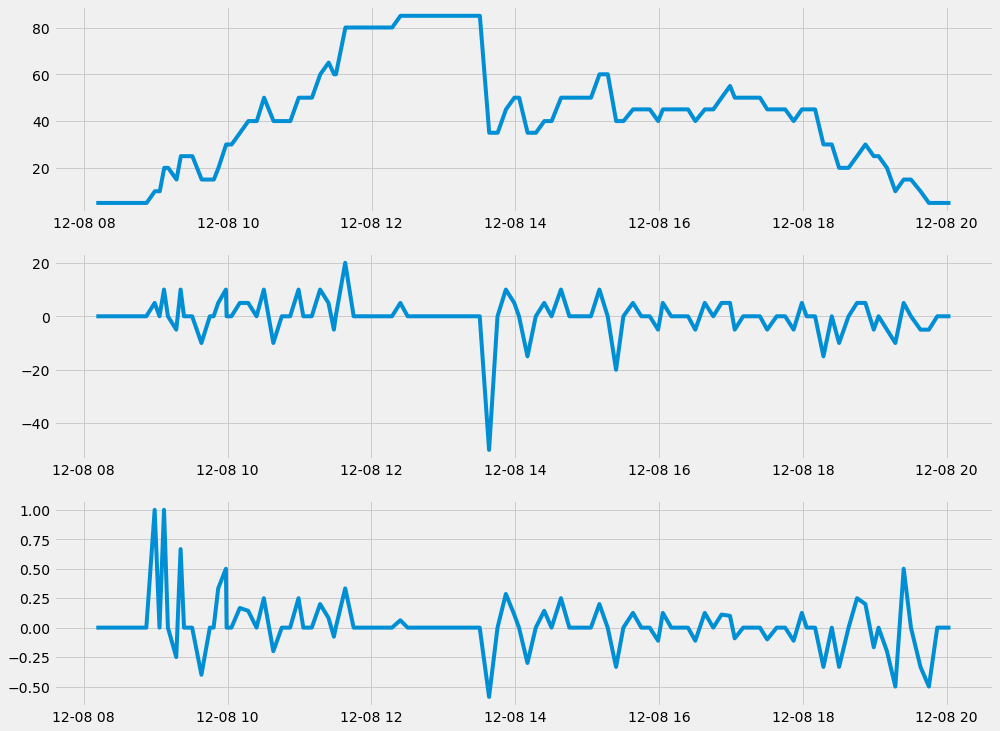

In [20]:
# Step 4: Plot hourly data for Saturday, Dec 8, 2018

# Plot unchanged, differenced, and percent change
fig, axes = plt.subplots(nrows = 3, figsize = (15, 12))
axes[0].plot(everest_Sat_Dec_08['SPOSTMIN'])
axes[1].plot(everest_Sat_Dec_08['SPOSTMIN'].diff())
axes[2].plot(everest_Sat_Dec_08['SPOSTMIN'].pct_change());

In [21]:
print(f"Minimum wait: {everest_Sat_Dec_08['SPOSTMIN'].min()}")
print(f"Maximum wait: {everest_Sat_Dec_08['SPOSTMIN'].max()}")

Minimum wait: 5.0
Maximum wait: 85.0


The greatest difference between the two hourly plots is that wait times on Saturday, Dec 8 exceeded 80 min, whereas wait times on Wednesday, Dec 5 barely exceeded 40.  On both days, wait times dipped around 1:30 - 2pm.  This isn't enough data to conclude that there is hourly seasonality, but guests wishing to ride Expedition Everest should check the ride's wait time around that time if they want to avoid purchasing a pass.

The second and third subplots show differenced data and percent change data respectively.  The differenced data still show the dips evident in the original data.  The bottom two subplots look similar.  The data are probably not stationary for Saturday, Dec 8, 2018.

I need to compare all Saturdays to all Wednesdays to get a better idea if hourly seasonality exists.

In [22]:
# Step 5: Create df for Saturdays only
everest_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']
saturdays = precovid.copy()

saturdays = saturdays[saturdays['day_name'] == 'Saturday']
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
199,2015-01-03,2015-01-03 07:47:23,NaN,5.0,6,Saturday
200,2015-01-03,2015-01-03 07:54:25,NaN,5.0,6,Saturday
201,2015-01-03,2015-01-03 08:05:24,NaN,5.0,6,Saturday
202,2015-01-03,2015-01-03 08:12:23,NaN,5.0,6,Saturday
203,2015-01-03,2015-01-03 08:19:29,NaN,5.0,6,Saturday


In [23]:
# Step 6: Create df for Wednesdays only
wednesdays = precovid.copy()

wednesdays = wednesdays[wednesdays['day_name'] == 'Wednesday']
wednesdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
534,2015-01-07,2015-01-07 08:00:36,NaN,5.0,3,Wednesday
535,2015-01-07,2015-01-07 08:01:12,NaN,5.0,3,Wednesday
536,2015-01-07,2015-01-07 08:09:27,NaN,10.0,3,Wednesday
537,2015-01-07,2015-01-07 08:10:18,NaN,10.0,3,Wednesday
538,2015-01-07,2015-01-07 08:21:55,NaN,15.0,3,Wednesday


In [24]:
saturdays['time'] = [d.time() for d in saturdays['datetime']]
wednesdays['time'] = [d.time() for d in wednesdays['datetime']]

In [25]:
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,time
199,2015-01-03,2015-01-03 07:47:23,NaN,5.0,6,Saturday,07:47:23
200,2015-01-03,2015-01-03 07:54:25,NaN,5.0,6,Saturday,07:54:25
201,2015-01-03,2015-01-03 08:05:24,NaN,5.0,6,Saturday,08:05:24
202,2015-01-03,2015-01-03 08:12:23,NaN,5.0,6,Saturday,08:12:23
203,2015-01-03,2015-01-03 08:19:29,NaN,5.0,6,Saturday,08:19:29


In [26]:
saturdays.dtypes

date        datetime64[ns]
datetime    datetime64[ns]
SACTMIN            float64
SPOSTMIN           float64
weekday              int64
day_name            string
time                object
dtype: object

In [27]:
temp_time = datetime.strptime('08:00:00', '%H:%M:%S').time()
saturdays = saturdays[saturdays['time'] > temp_time]
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,time
201,2015-01-03,2015-01-03 08:05:24,NaN,5.0,6,Saturday,08:05:24
202,2015-01-03,2015-01-03 08:12:23,NaN,5.0,6,Saturday,08:12:23
203,2015-01-03,2015-01-03 08:19:29,NaN,5.0,6,Saturday,08:19:29
204,2015-01-03,2015-01-03 08:26:22,NaN,5.0,6,Saturday,08:26:22
205,2015-01-03,2015-01-03 08:32:22,NaN,5.0,6,Saturday,08:32:22


In [28]:
saturdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,time
201,2015-01-03,2015-01-03 08:05:24,NaN,5.0,6,Saturday,08:05:24
202,2015-01-03,2015-01-03 08:12:23,NaN,5.0,6,Saturday,08:12:23
203,2015-01-03,2015-01-03 08:19:29,NaN,5.0,6,Saturday,08:19:29
204,2015-01-03,2015-01-03 08:26:22,NaN,5.0,6,Saturday,08:26:22
205,2015-01-03,2015-01-03 08:32:22,NaN,5.0,6,Saturday,08:32:22


In [29]:
temp_time = datetime.strptime('08:00:00', '%H:%M:%S').time()
wednesdays = wednesdays[wednesdays['time'] > temp_time]
wednesdays.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name,time
534,2015-01-07,2015-01-07 08:00:36,NaN,5.0,3,Wednesday,08:00:36
535,2015-01-07,2015-01-07 08:01:12,NaN,5.0,3,Wednesday,08:01:12
536,2015-01-07,2015-01-07 08:09:27,NaN,10.0,3,Wednesday,08:09:27
537,2015-01-07,2015-01-07 08:10:18,NaN,10.0,3,Wednesday,08:10:18
538,2015-01-07,2015-01-07 08:21:55,NaN,15.0,3,Wednesday,08:21:55


In [30]:
# resample to 10 min intervals to drop seconds and standardize across Saturdays
saturdays.set_index('datetime', inplace=True)
saturdays.resample('10min', loffset=pd.Timedelta('10min'))


/var/folders/pt/67q6zqvx64n047rqdkj_wx5c0000gn/T/ipykernel_3825/2061199249.py:3: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  saturdays.resample('10min', loffset=pd.Timedelta('10min'))


In [31]:
saturdays.dtypes

date        datetime64[ns]
SACTMIN            float64
SPOSTMIN           float64
weekday              int64
day_name            string
time                object
dtype: object

In [32]:
saturdays.head()

,date,SACTMIN,SPOSTMIN,weekday,day_name,time
datetime,,,,,,
2015-01-03 08:05:24,2015-01-03,NaN,5.0,6,Saturday,08:05:24
2015-01-03 08:12:23,2015-01-03,NaN,5.0,6,Saturday,08:12:23
2015-01-03 08:19:29,2015-01-03,NaN,5.0,6,Saturday,08:19:29
2015-01-03 08:26:22,2015-01-03,NaN,5.0,6,Saturday,08:26:22
2015-01-03 08:32:22,2015-01-03,NaN,5.0,6,Saturday,08:32:22


In [33]:
saturdays.set_index('time', inplace=True)


In [34]:
wednesdays.set_index('datetime', inplace=True)
wednesdays.resample('10min', loffset=pd.Timedelta('10min'))

/var/folders/pt/67q6zqvx64n047rqdkj_wx5c0000gn/T/ipykernel_3825/2490914169.py:2: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  wednesdays.resample('10min', loffset=pd.Timedelta('10min'))


In [35]:
wednesdays.head()

,date,SACTMIN,SPOSTMIN,weekday,day_name,time
datetime,,,,,,
2015-01-07 08:00:36,2015-01-07,NaN,5.0,3,Wednesday,08:00:36
2015-01-07 08:01:12,2015-01-07,NaN,5.0,3,Wednesday,08:01:12
2015-01-07 08:09:27,2015-01-07,NaN,10.0,3,Wednesday,08:09:27
2015-01-07 08:10:18,2015-01-07,NaN,10.0,3,Wednesday,08:10:18
2015-01-07 08:21:55,2015-01-07,NaN,15.0,3,Wednesday,08:21:55


In [36]:
wednesdays.set_index('time', inplace=True)

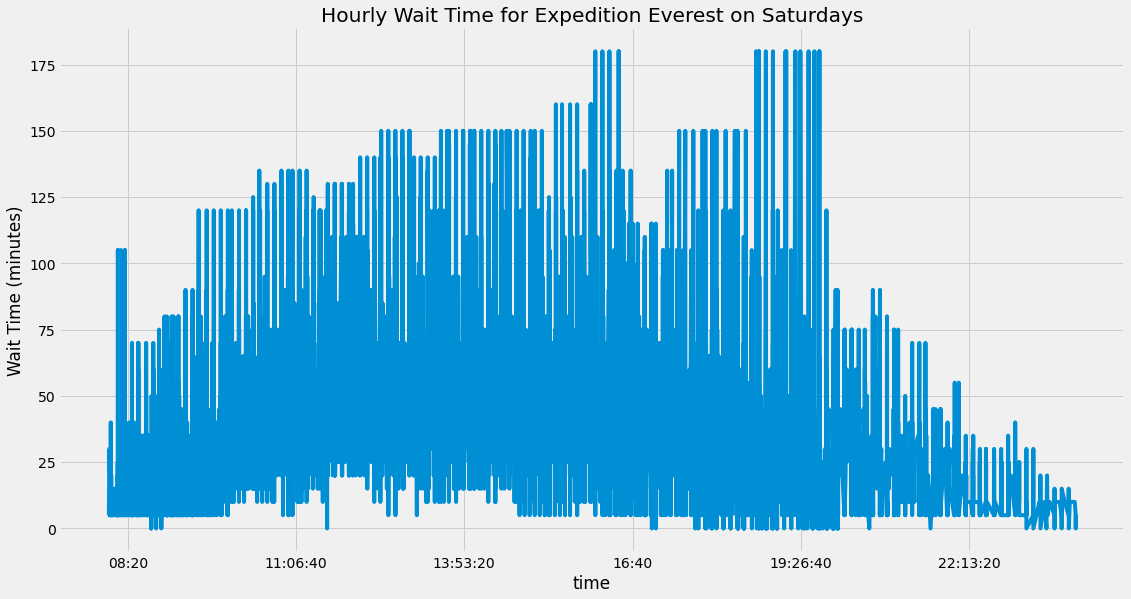

In [66]:
# Step 7: Plot hourly data for all Saturdays

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Expedition Everest on Saturdays")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

saturdays['SPOSTMIN'].plot();

Guests who visit the park on days when it's open later than 6 should plan to ride this ride after 6.  Guests who visit on a light day have more flexibility, but on too many Saturdays, wait times exceed 75 minutes almost all day.

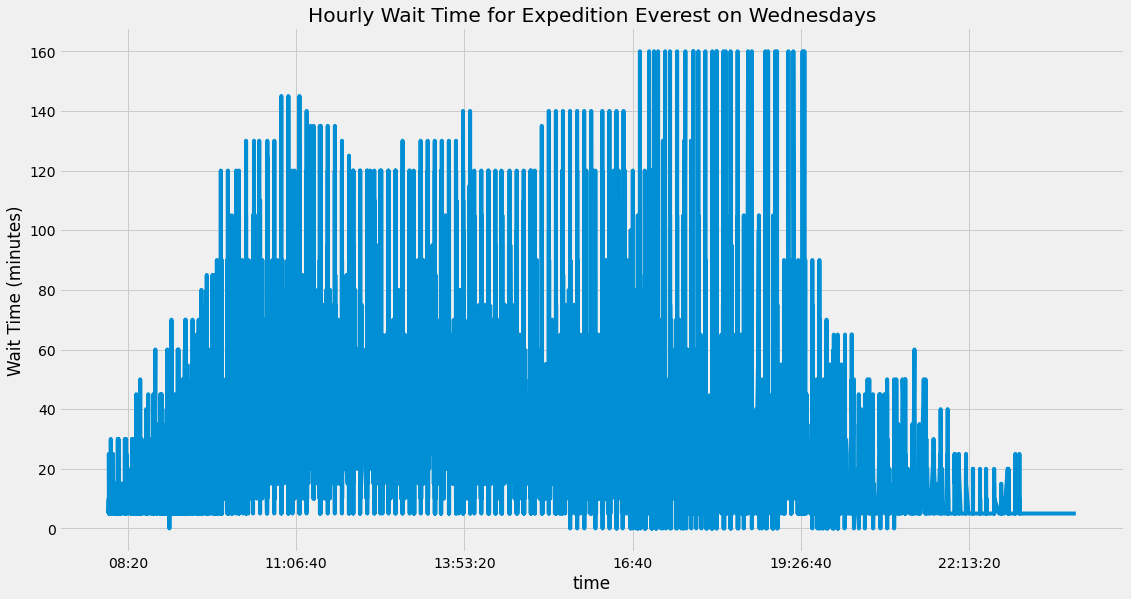

In [67]:
# Step 7: Plot hourly data for all Wednesdays

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Expedition Everest on Wednesdays")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

wednesdays['SPOSTMIN'].plot();

Overall, the darker pattern in this plot resembles the darker pattern in the Saturdays plot.  There might be hourly seasonality for this ride, but it's difficult to ascertain from these plots.

## Weekly Seasonality

Weekly seasonality must be considered, but it's tricky because spring break and Thanksgiving dates shift each year.  Spring break dates can shift by as much as 6 weeks.  Therefore, a customized approach is warranted.

First, I'll number each week of the year, beginning with the day after the Christmas - New Year's blockout dates end.  Week numbers for the first year will align with the calendar, aside from the brief offset for New Year's blockout dates.  For subsequent years, spring break weeks - as defined by Disney's blockout dates - will be switched to align with the first years.  In other words, spring breaks will always have the same week numbers, regardless of where they fall in the calendar.  I'll do the same with Thanksgiving and, if necessary, Christmas.

I realize this isn't a perfect system.  K-12 school districts tend to align to Easter; colleges and universities do not.  However, using Disney's self-declared blockout dates for lower-level passholders makes the system as equivalent as possible.

Another issue with this method is covid's timing.  Klimanjaro everests opened May 26, 2017, so it was only open for 1.5 years before covid began impacting tourism.  Therefore, for this ride and for Flight of Passage, I'll focus solely on August 1 - Dec 31 of 2017, 2018, 2019, and 2020.

In [39]:
precovid.head()

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
0,2015-01-01,2015-01-01 07:47:26,NaN,5.0,4,Thursday
1,2015-01-01,2015-01-01 07:54:23,NaN,5.0,4,Thursday
2,2015-01-01,2015-01-01 08:05:33,NaN,5.0,4,Thursday
3,2015-01-01,2015-01-01 08:12:23,NaN,5.0,4,Thursday
4,2015-01-01,2015-01-01 08:19:26,NaN,5.0,4,Thursday


In [40]:
# everest_Sat_Dec_08 = precovid[precovid['date'] == '2018-12-8']

In [41]:
# copy dataframe for backup
precovid_weekly = precovid_daily.copy()

# create day number
precovid_weekly['day_num'] = range(0, len(precovid_weekly))

# use day number to create and calculate week number
precovid_weekly['week_num'] = (precovid_weekly['day_num'] // 7)

# copy dataframe before indexing for future use
precovid_weekly_2 = precovid_weekly.copy()

# Create two copies: one for future indexing and one for other uses
precovid_weekly['week_number'] = precovid_weekly['week_num']

precovid_weekly.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_num,week_number
date,,,,,,,,,,
2015-01-01,2015-01-01 18:54:23,NaN,20.0,4,Thursday,2015-01-01,40.268817,0,0,0
2015-01-02,2015-01-02 19:54:22,NaN,5.0,5,Friday,2015-01-02,34.198113,1,0,0
2015-01-03,2015-01-03 18:54:22,NaN,15.0,6,Saturday,2015-01-03,29.793814,2,0,0
2015-01-04,2015-01-04 19:54:27,NaN,5.0,7,Sunday,2015-01-04,23.850000,3,0,0
2015-01-05,2015-01-05 16:54:24,NaN,10.0,1,Monday,2015-01-05,26.956522,4,0,0


In [42]:
# set index to week number
precovid_weekly.set_index('week_num', inplace=True)

# groupby week
precovid_weekly['avg_weekly_wait'] = precovid_weekly.groupby('week_num')['avg_daily_wait'].mean()

precovid_weekly['date'] = precovid_weekly['date2']

# set index to date
precovid_weekly.set_index('date', inplace=True)

# delete duplicates
precovid_weekly.drop_duplicates(subset='week_number', keep = 'last', inplace=True)

precovid_weekly.shape

(208, 10)

In [43]:
precovid_weekly.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2015-01-07,2015-01-07 16:54:22,NaN,15.0,3,Wednesday,2015-01-07,33.283582,6,0,30.716788
2015-01-14,2015-01-14 22:30:07,NaN,5.0,3,Wednesday,2015-01-14,13.794326,13,1,18.249938
2015-01-21,2015-01-21 17:00:07,NaN,5.0,3,Wednesday,2015-01-21,19.303279,20,2,28.514250
2015-01-28,2015-01-28 16:11:30,NaN,40.0,3,Wednesday,2015-01-28,21.666667,27,3,23.032050
2015-02-04,2015-02-04 18:00:06,NaN,5.0,3,Wednesday,2015-02-04,19.338843,34,4,21.883430


In [44]:
# Had to copy data first before limiting by date.  Didn't work when I tried to combine steps.
Aug17 = precovid_weekly.copy()
Aug18 = precovid_weekly.copy()

Aug17 = Aug17[Aug17['date2'] > '2017-07-31']
Aug17 = Aug17[Aug17['date2'] <= '2017-12-31']
Aug18 = Aug18[Aug18['date2'] > '2018-07-31']
Aug18 = Aug18[Aug18['date2'] <= '2018-12-31']

In [45]:
Aug18.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2018-08-01,2018-08-01 20:59:07,NaN,5.0,3,Wednesday,2018-08-01,28.928571,1301,185,34.683549
2018-08-08,2018-08-08 20:17:07,NaN,10.0,3,Wednesday,2018-08-08,28.981481,1308,186,33.725413
2018-08-15,2018-08-15 21:30:10,NaN,5.0,3,Wednesday,2018-08-15,28.125000,1315,187,35.192236
2018-08-22,2018-08-22 21:30:10,NaN,5.0,3,Wednesday,2018-08-22,29.750000,1322,188,29.602441
2018-08-29,2018-08-29 20:30:09,NaN,5.0,3,Wednesday,2018-08-29,18.050000,1329,189,30.006860


In [46]:
# Between covid and the ride opening in May, 2017, week_number in all Aug dfs must be 
# calibrated to be in sync with each other

Aug17['week_number'] = Aug17['week_number'] - 9
Aug18['week_number'] = Aug18['week_number'] - 61

In [47]:
Aug18.head(20)

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2018-08-01,2018-08-01 20:59:07,NaN,5.0,3,Wednesday,2018-08-01,28.928571,1301,124,34.683549
2018-08-08,2018-08-08 20:17:07,NaN,10.0,3,Wednesday,2018-08-08,28.981481,1308,125,33.725413
2018-08-15,2018-08-15 21:30:10,NaN,5.0,3,Wednesday,2018-08-15,28.125000,1315,126,35.192236
2018-08-22,2018-08-22 21:30:10,NaN,5.0,3,Wednesday,2018-08-22,29.750000,1322,127,29.602441
2018-08-29,2018-08-29 20:30:09,NaN,5.0,3,Wednesday,2018-08-29,18.050000,1329,128,30.006860
2018-09-05,2018-09-05 20:30:12,NaN,5.0,3,Wednesday,2018-09-05,11.250000,1336,129,22.813700
2018-09-12,2018-09-12 20:30:10,NaN,5.0,3,Wednesday,2018-09-12,33.732394,1343,130,21.948487
2018-09-19,2018-09-19 19:59:08,NaN,5.0,3,Wednesday,2018-09-19,17.528090,1350,131,22.188721
2018-09-26,2018-09-26 19:59:08,NaN,5.0,3,Wednesday,2018-09-26,14.252336,1357,132,22.575723


In [48]:
# Thanksgiving, 2017 = Nov 23; Thanksgiving, 2018 = Nov 22.  They have the same week number.

In [49]:
# copy dataframe for backup
covid_weekly = covid.copy()


# create day number
covid_weekly['day_num'] = range(0, len(covid_weekly))

# use day number to create and calculate week number
covid_weekly['week_num'] = (covid_weekly['day_num'] // 7)

# copy dataframe before indexing for future use
covid_weekly_2 = covid_weekly.copy()

covid_weekly['week_number'] = covid_weekly['week_num']

# Group waiting times by date to get avg_daily_posted_wait
covid_weekly['avg_daily_wait'] = covid_weekly.groupby('date2')['SPOSTMIN'].mean()

# set index to week number
covid_weekly.set_index('week_num', inplace=True)

# groupby week
covid_weekly['avg_weekly_wait'] = covid_weekly.groupby('week_num')['avg_daily_wait'].mean()

covid_weekly['date'] = covid_weekly['date2']

# set index to date
covid_weekly.set_index('date', inplace=True)

# delete duplicates
covid_weekly.drop_duplicates(subset='week_number', keep = 'last', inplace=True)

covid_weekly.head()


,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2019-07-22,2019-07-22 23:24:02,NaN,10.0,1,Monday,2019-07-22,10.0,6,0,8.571429
2019-07-29,2019-07-29 23:59:02,NaN,5.0,1,Monday,2019-07-29,5.0,13,1,7.857143
2019-08-05,2019-08-05 23:59:02,NaN,5.0,1,Monday,2019-08-05,5.0,20,2,6.428571
2019-08-12,2019-08-12 23:59:02,NaN,5.0,1,Monday,2019-08-12,5.0,27,3,12.857143
2019-08-19,2019-08-19 23:59:02,NaN,5.0,1,Monday,2019-08-19,5.0,34,4,8.571429


In [50]:
Aug19 = covid_weekly.copy()
Aug20 = covid_weekly.copy()

Aug19 = Aug19[Aug19['date2'] > '2019-07-31']
Aug19 = Aug19[Aug19['date2'] <= '2019-12-31']
Aug20 = Aug20[Aug20['date2'] > '2020-07-31']
Aug20 = Aug20[Aug20['date2'] <= '2020-12-31']

# Offsets needed to sync up Thanksgiving to same week number (roughly)
Aug19['week_number'] = Aug19['week_number'] - 2
Aug20['week_number'] = Aug20['week_number'] - 24

In [51]:
Aug20.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait,day_num,week_number,avg_weekly_wait
date,,,,,,,,,,
2020-11-05,2020-11-05 16:59:01,NaN,10.0,4,Thursday,2020-11-05,10.0,258,12,19.285714
2020-11-12,2020-11-12 18:10:01,NaN,25.0,4,Thursday,2020-11-12,25.0,265,13,16.428571
2020-11-19,2020-11-19 16:59:01,NaN,5.0,4,Thursday,2020-11-19,5.0,272,14,12.142857
2020-11-26,2020-11-26 19:59:01,NaN,10.0,4,Thursday,2020-11-26,10.0,279,15,20.714286
2020-12-03,2020-12-03 17:03:02,NaN,15.0,4,Thursday,2020-12-03,15.0,286,16,18.571429


### Weekly EDA

In [52]:
precovid_weekly.set_index('date2', inplace=True)

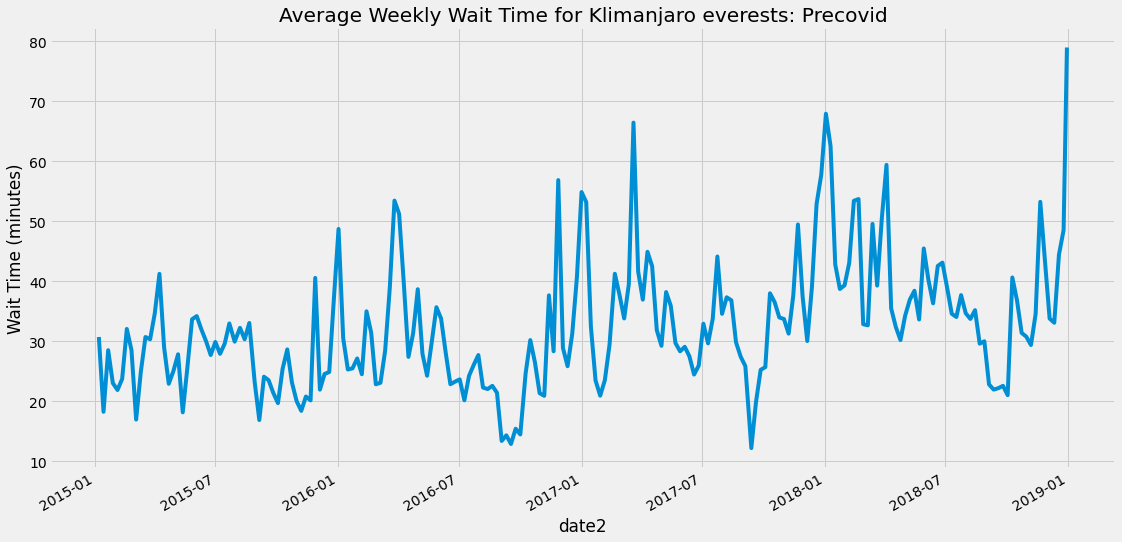

In [53]:
plt.figure(figsize = (17, 9))
plt.title("Average Weekly Wait Time for Klimanjaro everests: Precovid")
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

precovid_weekly['avg_weekly_wait'].plot();

There is definite weekly fluctuation, but it doesn't appear to form a clear pattern.  The major spike at December, 2017 is due to higher park attendance at Christmas. There are similar, though smaller, spikes in November and December, 2018.  In Florida, summer vacation begins in mid-May and ends in early to mid-August.  The smaller spikes in late May, 2018 and 2019 likely are due to summer vacation for local schoolchildren.

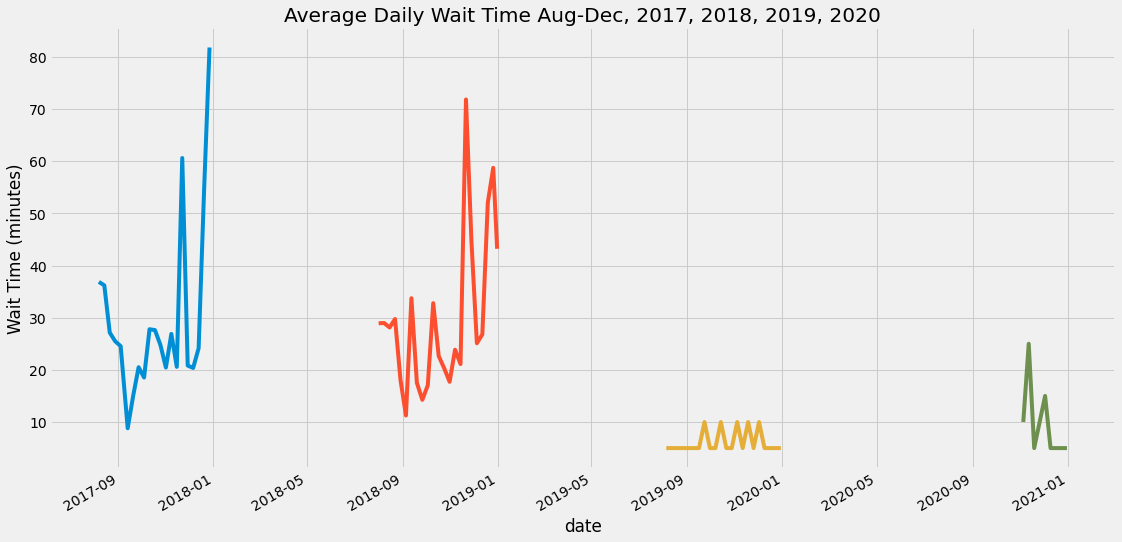

In [54]:
plt.figure(figsize = (17, 9))
plt.title("Average Daily Wait Time Aug-Dec, 2017, 2018, 2019, 2020")
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

Aug17['avg_daily_wait'].plot()
Aug18['avg_daily_wait'].plot()
Aug19['avg_daily_wait'].plot()
Aug20['avg_daily_wait'].plot();

The trends between 2018 and 2018 appear very similar.  The trends between 2019 and 2020 cannot be compared.

In [55]:
Aug17.set_index('week_number', inplace=True)
Aug18.set_index('week_number', inplace=True)
Aug19.set_index('week_number', inplace=True)
Aug20.set_index('week_number', inplace=True)

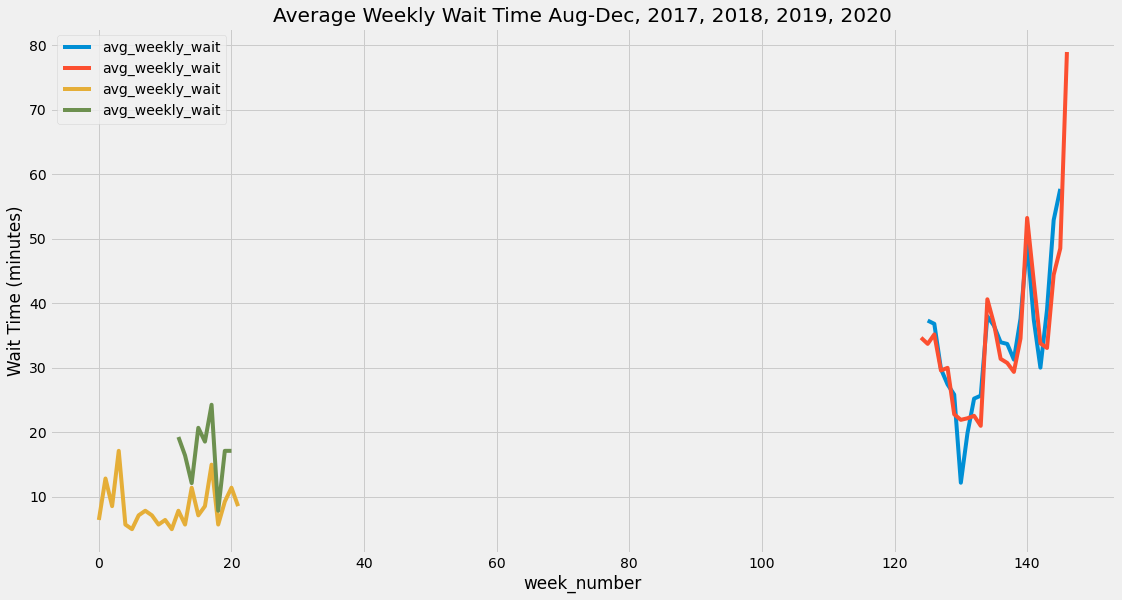

In [56]:
plt.figure(figsize = (17, 9))
plt.title("Average Weekly Wait Time Aug-Dec, 2017, 2018, 2019, 2020")
plt.xlabel('Date')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

Aug17['avg_weekly_wait'].plot()
Aug18['avg_weekly_wait'].plot()
Aug19['avg_weekly_wait'].plot()
Aug20['avg_weekly_wait'].plot()
plt.legend();

2017: Blue Line
2018: Red Line
2019: Yellow Line
2020: Green Line

By calibrating all years by week number, I can plot the average daily wait times on the same graph.  2017 and 2018 look very similar.

Again, the only thing to be said about 2019 and 2020 is that wait times dropped tremendously.  

# Modeling

## Precovid Null Model

In [57]:
# Overall average wait time before covid
precovid['SPOSTMIN'].mean()

34.316142087273796

In this case, the null model is the mean wait time before covid, or 70 minutes.  I calculated this figure using the original data but excluding all dates after March 15, 2020.

In [58]:
precovid_weekly_2 = precovid_weekly.copy()

In [59]:
# for prediction purposes, I want a one year dataset unaffected by covid and the ride's grand opening
precovid_weekly_2 = precovid_weekly_2[precovid_weekly_2['datetime'] > '2017-08-01']
precovid_weekly_2 = precovid_weekly_2[precovid_weekly_2['datetime'] < '2018-08-01']
precovid_weekly_2.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,avg_daily_wait,day_num,week_number,avg_weekly_wait
date2,,,,,,,,,
2017-08-07,2017-08-07 22:03:06,NaN,10.0,1,Monday,36.865079,944,134,37.335972
2017-08-14,2017-08-14 22:03:14,NaN,20.0,1,Monday,36.201550,951,135,36.829857
2017-08-21,2017-08-21 21:30:12,NaN,5.0,1,Monday,27.132353,958,136,29.831855
2017-08-28,2017-08-28 21:30:09,NaN,5.0,1,Monday,25.476190,965,137,27.434092
2017-09-04,2017-09-04 21:03:08,NaN,5.0,1,Monday,24.545455,972,138,25.862087


In [68]:
precovid_weekly_2.tail()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,avg_daily_wait,day_num,week_number,avg_weekly_wait
date2,,,,,,,,,
2018-06-27,2018-06-27 22:30:09,NaN,5.0,3,Wednesday,38.333333,1266,180,43.113550
2018-07-04,2018-07-04 22:30:09,NaN,5.0,3,Wednesday,32.198276,1273,181,38.971439
2018-07-11,2018-07-11 22:30:09,NaN,5.0,3,Wednesday,31.653543,1280,182,34.591400
2018-07-18,2018-07-18 22:30:09,NaN,5.0,3,Wednesday,44.827586,1287,183,34.050254
2018-07-25,2018-07-25 22:30:09,NaN,5.0,3,Wednesday,35.299145,1294,184,37.698602


## Covid Null Model

In [61]:
# Overall average wait time during covid
covid_null = covid[covid['date2'] < '2021-09-01']
covid_null['SPOSTMIN'].mean()

10.546594982078853

In [62]:
covid.head(3)

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2019-07-16,2019-07-16 20:59:01,NaN,5.0,2,Tuesday,2019-07-16,49.950000
2019-07-17,2019-07-17 20:59:02,NaN,5.0,3,Wednesday,2019-07-17,39.333333
2019-07-18,2019-07-18 23:59:01,NaN,15.0,4,Thursday,2019-07-18,44.425287


## ACF and PACF Plots

### 1 Year Plots

All of these plots use data that starts in August, 2017.

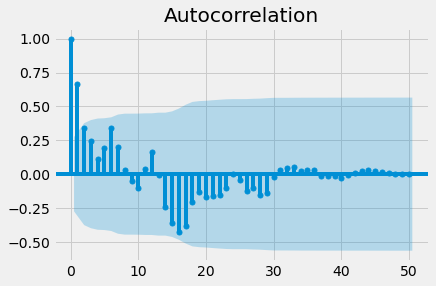

In [72]:
# Weekly ACF plot for May 26, 2017 - May 26, 2018: pre-covid
# X-axis = week number
plot_acf(precovid_weekly_2['avg_weekly_wait'], lags=50)
plt.show()

This plot shows neglible indications of seasonality.

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


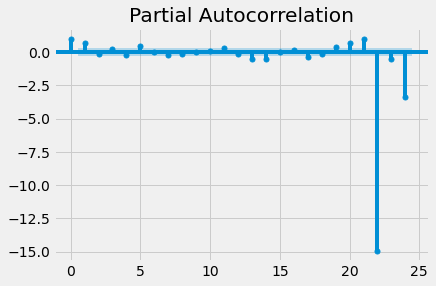

In [71]:
# Weekly PACF plot for May 26, 2017 - May 26, 2018: pre-covid
plot_pacf(precovid_weekly_2['avg_weekly_wait'], lags=24)
plt.show()

This plot shows a sharp decline around Spring, 2018.  I found evidence of closure in July, 2018, but that's outside of this data range.  The article mentioned an ongoing problem, however, so perhaps there was a closure in the spring.

### 90 Day ACF and PACF Plots

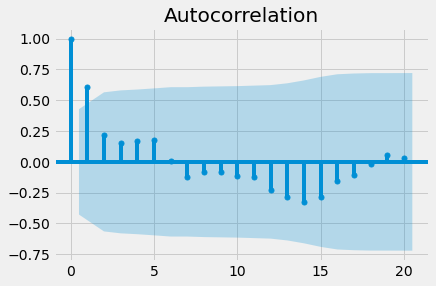

In [75]:
# 5 month plot, beginning Aug 1, 2017 (roughly 5 months)
plot_acf(Aug17['avg_weekly_wait'], lags=20)
plt.show()

Autocorrelation really only lasts for 1 week.

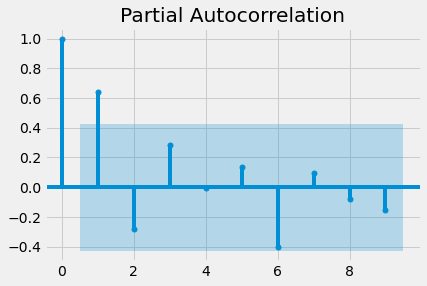

In [77]:
# 13 Week plot beginning Aug 1, 2017 (roughly 3 months)
plot_pacf(Aug17['avg_weekly_wait'], lags=9)
plt.show()

Partial autocorrelation is only observed the first week.

In [ ]:
Aug18.head(25)

### Decomposition

In [78]:
precovid_daily.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2015-01-01,2015-01-01 18:54:23,NaN,20.0,4,Thursday,2015-01-01,40.268817
2015-01-02,2015-01-02 19:54:22,NaN,5.0,5,Friday,2015-01-02,34.198113
2015-01-03,2015-01-03 18:54:22,NaN,15.0,6,Saturday,2015-01-03,29.793814
2015-01-04,2015-01-04 19:54:27,NaN,5.0,7,Sunday,2015-01-04,23.850000
2015-01-05,2015-01-05 16:54:24,NaN,10.0,1,Monday,2015-01-05,26.956522


<Figure size 432x288 with 0 Axes>

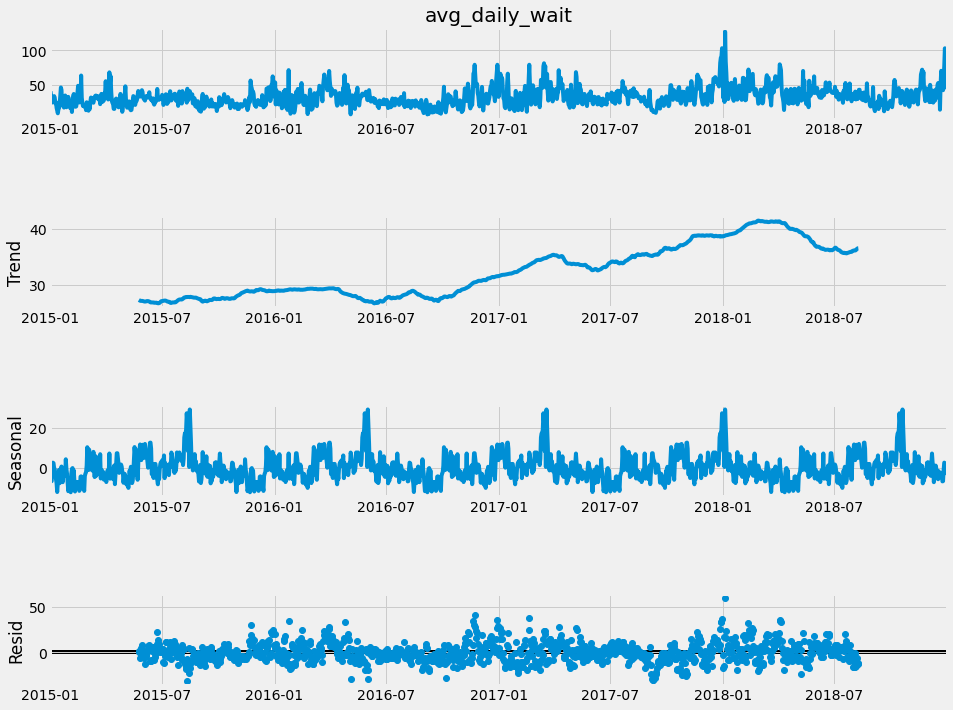

In [79]:
# Daily seasonality?

decomp_daily = seasonal_decompose(precovid_daily.avg_daily_wait, period = 289)
fig = plt.figure()
fig = decomp_daily.plot()
fig.set_size_inches(15, 12);

Decomposition of average daily wait times shows fluctuation, but not necessarily seasonality.  The residuals are pretty evenly distributed.  The seasonal decomposition shows several spikes, but they're not in the same months.

<Figure size 432x288 with 0 Axes>

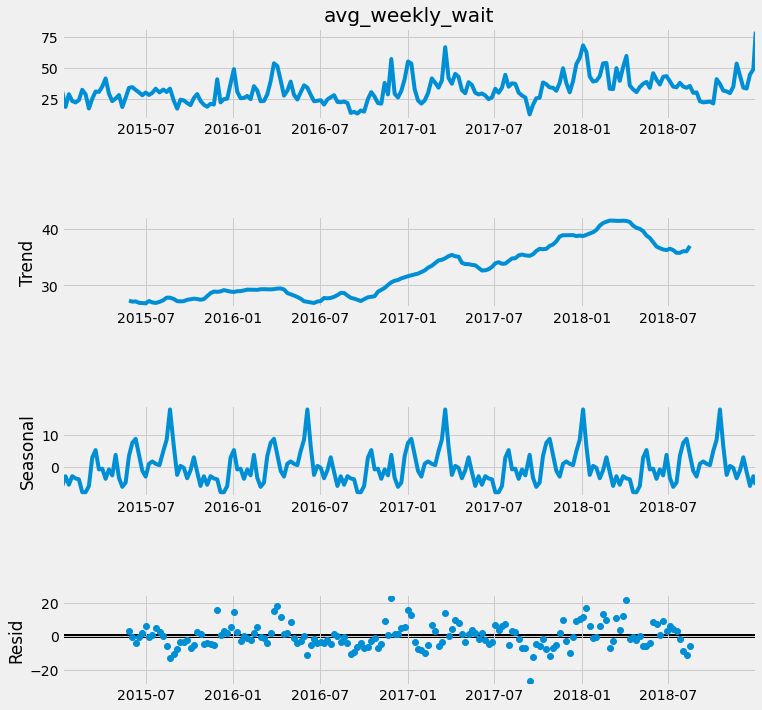

In [80]:
# Weekly seasonality?

decomp_weekly = seasonal_decompose(precovid_weekly.avg_weekly_wait, period = 41)
fig = plt.figure()
fig = decomp_weekly.plot()
fig.set_size_inches(12, 12);


The weekly decomposition plots look very similar to the daily decomposition plots.  However, the weekly residuals show some spikes.  An Adfuller test definitely is needed to determine stationarity.

In [ ]:
precovid_weekly_3 = pd.DataFrame(precovid_weekly['avg_weekly_wait'])

# RESAMPLE SO SARIMAX WILL WORK (ride closures caused some irregularities)
precovid_weekly_3.resample('D').interpolate()[::7]

# from https://stackoverflow.com/questions/14530556/resample-time-series-in-pandas-to-a-weekly-interval

In [ ]:
covid_weekly_3 = pd.DataFrame(covid_weekly['avg_weekly_wait'])

# RESAMPLE SO SARIMAX WILL WORK (ride closures caused some irregularities)
covid_weekly_3.resample('D').interpolate()[::7]

# from https://stackoverflow.com/questions/14530556/resample-time-series-in-pandas-to-a-weekly-interval

In [ ]:
# covid_weekly_3 = pd.DataFrame(covid_weekly['avg_weekly_wait'])

In [ ]:
#covid.tail(50)

There are insufficient data and too many large gaps to predict wait times on a weekly basis, so I must use daily data.  The next question is which "precovid" data to use: 2018, 2019, or 2020?  The parks were closed from mid-March - mid-July, 2019.  Disney is still not running at full capacity, so if those data are availble, they might predict wait times better than 2018 data.  I lack the data for 2020, so that's not an option.

## Predict Wait Times for Autumn, 2021

### Option 1 (Null Model):
Remember, the null model is that guests will wait 29 minutes to ride this ride.

### Option 2: ARIMA

In [105]:
# for future use
y_train_sarimax = precovid_weekly_2[precovid_weekly_2['datetime'] < '2019-12-29']

# Modify dfs to make them the same length[Aug 30 - Dec 28, 2021 & Aug 30 - Dec 28, 2019]
y_train = covid[covid['date2'] > '2019-08-29']
y_train = y_train[y_train['date2'] < '2019-12-29']
y_test = covid[covid['date2'] > '2021-08-29']

In [82]:
y_train.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2019-08-30,2019-08-30 21:24:02,NaN,5.0,5,Friday,2019-08-30,17.429907
2019-08-31,2019-08-31 21:24:02,NaN,5.0,6,Saturday,2019-08-31,19.954955
2019-09-01,2019-09-01 21:24:02,NaN,10.0,7,Sunday,2019-09-01,15.761905
2019-09-02,2019-09-02 21:31:02,NaN,5.0,1,Monday,2019-09-02,14.166667
2019-09-03,2019-09-03 13:59:02,NaN,5.0,2,Tuesday,2019-09-03,9.464286


In [83]:
y_test.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
date,,,,,,,
2021-08-30,2021-08-30 18:59:07,NaN,5.0,1,Monday,2021-08-30,5.776699
2021-08-31,2021-08-31 18:59:08,NaN,5.0,2,Tuesday,2021-08-31,8.600000
2021-09-01,2021-09-01 18:31:17,NaN,5.0,3,Wednesday,2021-09-01,7.714286
2021-09-02,2021-09-02 18:10:22,NaN,5.0,4,Thursday,2021-09-02,7.842105
2021-09-03,2021-09-03 18:45:14,NaN,5.0,5,Friday,2021-09-03,8.774510


Aug 30, 2019 was a Friday; Aug 30, 2021 was a Monday.  I need to modify the dataframes and index them by day_number (new field), so that the days of the week match up, even though actual dates will differ by a few days.

I would start y_train on Monday, Sept 2, 2019 instead of August 30, but that was Labor Day. Sept 6, 2021 was Labor Day.  There's no perfect way to adjust for this.  I'll manually recode the respective dates as Sundays instead of Mondays to predict crowds better.  The plots won't match, but in the final analysis (predicting actual wait times vs predicted), it will be fine.

In [84]:
# Add day_number and make it index in both dfs

y_train['day_number'] = range(1, 1 + len(y_train))
y_test['day_number'] = range(1, 1 + len(y_test))

y_train.set_index('day_number', inplace=True)
y_test.set_index('day_number', inplace=True)

/var/folders/pt/67q6zqvx64n047rqdkj_wx5c0000gn/T/ipykernel_3825/3422483454.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['day_number'] = range(1, 1 + len(y_test))


In [85]:
y_train

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
day_number,,,,,,,
1,2019-08-30 21:24:02,NaN,5.0,5,Friday,2019-08-30,17.429907
2,2019-08-31 21:24:02,NaN,5.0,6,Saturday,2019-08-31,19.954955
3,2019-09-01 21:24:02,NaN,10.0,7,Sunday,2019-09-01,15.761905
4,2019-09-02 21:31:02,NaN,5.0,1,Monday,2019-09-02,14.166667
5,2019-09-03 13:59:02,NaN,5.0,2,Tuesday,2019-09-03,9.464286
...,...,...,...,...,...,...,...
117,2019-12-24 20:59:02,NaN,5.0,2,Tuesday,2019-12-24,70.505051
118,2019-12-25 20:59:02,NaN,10.0,3,Wednesday,2019-12-25,48.584071
119,2019-12-26 20:59:02,NaN,25.0,4,Thursday,2019-12-26,57.716049


In [86]:
y_test

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,date2,avg_daily_wait
day_number,,,,,,,
1,2021-08-30 18:59:07,NaN,5.0,1,Monday,2021-08-30,5.776699
2,2021-08-31 18:59:08,NaN,5.0,2,Tuesday,2021-08-31,8.600000
3,2021-09-01 18:31:17,NaN,5.0,3,Wednesday,2021-09-01,7.714286
4,2021-09-02 18:10:22,NaN,5.0,4,Thursday,2021-09-02,7.842105
5,2021-09-03 18:45:14,NaN,5.0,5,Friday,2021-09-03,8.774510
...,...,...,...,...,...,...,...
117,2021-12-24 20:00:23,NaN,5.0,5,Friday,2021-12-24,31.031746
118,2021-12-25 20:00:18,NaN,5.0,6,Saturday,2021-12-25,29.000000
119,2021-12-26 20:00:26,NaN,5.0,7,Sunday,2021-12-26,30.930233


In [87]:
# For use in future, custom model
custom_21 = y_test.copy()

In [88]:
# These are daily data.
y_train = pd.DataFrame(y_train['avg_daily_wait'])
y_test = pd.DataFrame(y_test['avg_daily_wait'])

In [89]:
# From lesson 9.3, Hank Butler
# start with really high AIC, initialize p and q to zero
# loop through to find best aic, p, and q
# Starting AIC, p, and q.

best_aic = 99 * (10 ** 16)
best_p = 0
best_q = 0

# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):

        try:
            
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p}, 1, {q})')
            
            # Instantiate ARIMA model.
            arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = y - variable
                         order = (p, 1, q)) # values of p, d, q
            
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},1,{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic:
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0, 1, 0)
RUNNING THE L-BFGS-B CODE

           * * *

The AIC for ARIMA(0,1,0) is: 932.9326135688443Machine precision = 2.220D-16
 N =            1     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.87055D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   3.871D+00
  F =   3.8705525565368513     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

Attempting to fit ARIMA(0, 1, 1)


/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84770D+00    |proj g|=  9.16556D-04

At iterate    5    f=  3.84769D+00    |proj g|=  1.33227D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     10      1     0     0   0.000D+00   3.848D+00
  F =   3.8476935192324691     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
The AIC for ARIMA(0,1,1) is: 929.4464446157925
Attempting to fit ARIMA(0, 1, 2)
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and


At iterate    5    f=  3.77289D+00    |proj g|=  5.92904D-04

At iterate   10    f=  3.77289D+00    |proj g|=  1.28786D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   4.441D-08   3.773D+00
  F =   3.7728888485458314     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(0,1,4) is: 917.4933236509995
Attempting to fit ARIMA(1, 1, 0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84691D+00    |proj g|=  8.

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forec

Attempting to fit ARIMA(1, 1, 4)
Attempting to fit ARIMA(2, 1, 0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84670D+00    |proj g|=  6.08935D-04

At iterate    5    f=  3.84670D+00    |proj g|=  2.88214D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   4.441D-08   3.847D+00
  F =   3.8467004612000109     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(2,1,0) is: 931.2081106880026
Attempting to fit A

 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.



At iterate    5    f=  3.79788D+00    |proj g|=  8.07012D-03

At iterate   10    f=  3.79601D+00    |proj g|=  1.82876D-03

At iterate   15    f=  3.79591D+00    |proj g|=  7.60902D-04

At iterate   20    f=  3.79591D+00    |proj g|=  2.39764D-04

At iterate   25    f=  3.79591D+00    |proj g|=  1.26477D-04

At iterate   30    f=  3.79591D+00    |proj g|=  6.49703D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was 


At iterate   35    f=  3.79591D+00    |proj g|=  8.09131D-05

At iterate   40    f=  3.79591D+00    |proj g|=  7.59837D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40    113      2     0     0   7.598D-05   3.796D+00
  F =   3.7959102258412329     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(2,1,2) is: 923.0184542018959
Attempting to fit ARIMA(2, 1, 3)
Attempting to fit ARIMA(2, 1, 4)
Attempting to fit ARIMA(3, 1, 0)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           12

At X0         0 variables are exactly 

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forec


At iterate    5    f=  3.78058D+00    |proj g|=  2.79021D-04

At iterate   10    f=  3.78058D+00    |proj g|=  2.26485D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   8.882D-08   3.781D+00
  F =   3.7805836093177598     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(3,1,1) is: 919.3400662362624
Attempting to fit ARIMA(3, 1, 2)
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78066D+00    |proj g|=  7.

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsu

 N =            6     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.79925D+00    |proj g|=  3.98104D-03

At iterate    5    f=  3.79917D+00    |proj g|=  6.25500D-04

At iterate   10    f=  3.79917D+00    |proj g|=  2.29150D-05

At iterate   15    f=  3.79917D+00    |proj g|=  4.44089D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     22      1     0     0   8.882D-08   3.799D+00
  F =   3.7991682517200362     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The AIC for ARIMA(4,1,1) is: 925.8003804128087
Attempting to fit ARIMA(4, 1, 2)


/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77853D+00    |proj g|=  1.78308D-01

At iterate    5    f=  3.76936D+00    |proj g|=  1.20006D-03

At iterate   10    f=  3.76933D+00    |proj g|=  1.62474D-03

At iterate   15    f=  3.76926D+00    |proj g|=  1.21947D-04

At iterate   20    f=  3.76926D+00    |proj g|=  3.10862D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     30      1     0     0   2.665D-07   3.769D+00
  F =   3.7692590413506264     

CONVERG

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:726: RuntimeWarning: invalid value encountered in double_scalars
  tmp[kiter] = (macoefs[kiter]-b *macoefs[j-kiter-1])/(1-b**2)
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:728: RuntimeWarning: divide by zero encountered in log
  invmacoefs = -np.log((1-macoefs)/(1+macoefs))
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-pack

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           12

At X0         0 variables are exactly at the bounds
Attempting to fit ARIMA(4, 1, 4)
At iterate    0    f=          NaN    |proj g|=          NaN

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75523D+00    |proj g|=  5.17264D-02

At iterate    5    f=  3.75408D+00    |proj g|=  7.18976D-03

At iterate   10    f=  3.75307D+00    |proj g|=  1.12943D-02

At iterate   15    f=  3.75186D+00    |proj g|=  4.82387D-03

At iterate   20    f=  3.75154D+00    |proj g|=  2.18336D-03

At iterate   25    f=  3.75145D+00    |proj g|=  2.30820D-03


/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  3.75143D+00    |proj g|=  7.01394D-04

At iterate   35    f=  3.75141D+00    |proj g|=  2.14158D-03

At iterate   40    f=  3.75141D+00    |proj g|=  7.62945D-05

At iterate   45    f=  3.75141D+00    |proj g|=  6.25278D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   50    f=  3.75141D+00    |proj g|=  5.87086D-05

At iterate   55    f=  3.75141D+00    |proj g|=  8.47322D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-5.694E-13  -gs= 1.799E-12 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     59    183      5     1     0   2.072D-04   3.751D+00
  F =   3.7514059881492918     

ABNORMAL_TERMINATION_IN_LNSRCH                              
The AIC for ARIMA(4,1,4) is: 920.33743715583


MODEL FINISHED!
Our model that minimizes AIC on the training data is the ARIMA(0,1,4).
This model has an AIC of 917.4933236509995.



 Line search cannot locate an adequate point after 20 function
  and gradient evaluations.  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Since dataset is small, do manually.  No seasonality, just straight-up ARIMA
#factors = pmd.auto_arima(y_train['avg_daily_wait'], m=31, trace=True)

# best model = AIC = 917.4933; (0, 1, 4)

In [92]:
# Instantiate best model.
model = ARIMA(endog = y_train.astype(float).dropna(),
             order = (0, 1, 4))


# Fit ARIMA model.
arima = model.fit()

# Generate predictions based on test set.
preds = model.predict(params = arima.params,
                     start = y_test.index[0],
                     end = y_test.index[-1])



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.77599D+00    |proj g|=  1.09244D-01

At iterate    5    f=  3.77289D+00    |proj g|=  5.92904D-04

At iterate   10    f=  3.77289D+00    |proj g|=  1.28786D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   4.441D-08   3.773D+00
  F =   3.7728888485458314     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
 This problem is unconstrained.
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [93]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:       D.avg_daily_wait   No. Observations:                  120
Model:                 ARIMA(0, 1, 4)   Log Likelihood                -452.747
Method:                       css-mle   S.D. of innovations             10.362
Date:                Tue, 18 Jan 2022   AIC                            917.493
Time:                        15:22:55   BIC                            934.218
Sample:                             1   HQIC                           924.285
                                                                              
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.3494      0.065      5.384      0.000       0.222       0.477
ma.L1.D.avg_daily_wait    -0.4005      0.093     -4.328      0.000      -0.582      -0.219
ma.L2.D.avg_daily_wait    -0.0764      0.091     -0.836      0.403      -0.255       0.103
ma.L3.D.avg_daily_wait    -0.1774      0.105     -1.682      0.093      -0.384       0.029
ma.L4.D.avg_daily_wait    -0.3457      0.094     -3.686      0.000      -0.530      -0.162
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2            0.0318           -1.3540j            1.3544           -0.2463
MA.3            0.0318           +1.3540j            1.3544            0.2463
MA.4           -1.5768           -0.0000j            1.5768           -0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
# RMSE = .091 - .105, std error of constant = .065
# Based on the P values, the data are stationary when difference once or 4 times (alpha = .05)

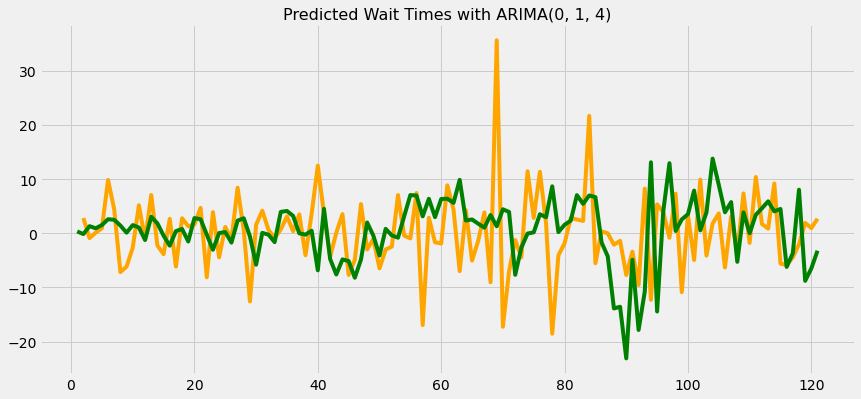

In [95]:
# Plot data.
plt.figure(figsize=(13,6))

# Plot training data.
#plt.plot(y_train.index, pd.DataFrame(y_train).diff(), color = 'blue')

# Plot testing data.
plt.plot(y_test.index, pd.DataFrame(y_test).diff(), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Predicted Wait Times with ARIMA(0, 1, 4)', fontsize=16)
plt.show();

The blue line represents 2019 (train) data; the orange line represents 2021 (test) data. The green line represents the predicted wait times.

To plot the two time series on the same timeframe, I replaced the respective date indices with a day_number index, beginning on Aug 30 and ending on Dec 28 of the respective years.

This ARIMA model doesn't do as well as those for Na'vi River Journey and Flight of Passage.  This is reasonable, since there is far more data for Kilimanjaro everests, since it opened a few years before the other rides.  There is also a random factor with this ride: Ocasionally, an animal hangs out in the path of a everest vehicle and everything grinds to a halt until the animal clears the path from a safe distance.  This can take anywhere from a few minutes to however long the animal wishes to hang out.  Even with this unpredictability, it appears that the ARIMA model is most accurate around Aug, Nov, and Dec.  September and October's predictions are especially wrong.

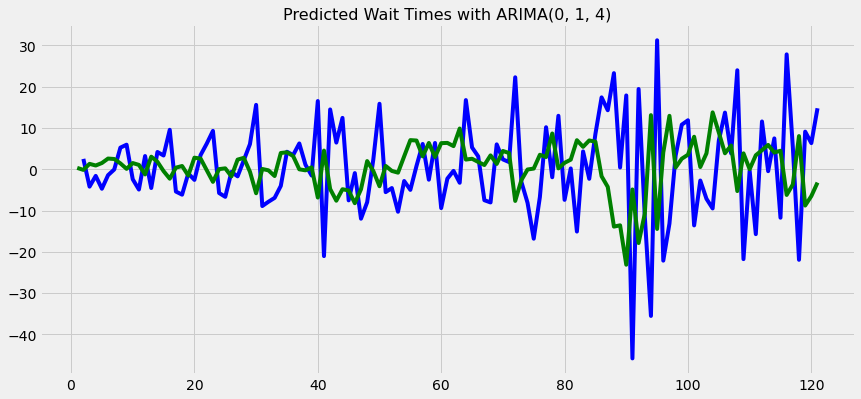

In [96]:
# Plot data.
plt.figure(figsize=(13,6))

# Plot training data.
plt.plot(y_train.index, pd.DataFrame(y_train).diff(), color = 'blue')

# Plot testing data.
#plt.plot(y_test.index, pd.DataFrame(y_test).diff(), color = 'orange')

# Plot predicted test values.
plt.plot(y_test.index, preds, color = 'green')

plt.title(label = 'Predicted Wait Times with ARIMA(0, 1, 4)', fontsize=16)
plt.show();

In [97]:
adfuller(y_train['avg_daily_wait'])

(-3.283375888365688,
 0.015638124686282458,
 0,
 120,
 {'1%': -3.486055829282407,
  '5%': -2.8859430324074076,
  '10%': -2.5797850694444446},
 831.7187507607359)

In [99]:
adfuller(precovid_weekly_2['avg_weekly_wait'])

(-1.773794687271305,
 0.39354730496359014,
 4,
 46,
 {'1%': -3.5812576580093696,
  '5%': -2.9267849124681518,
  '10%': -2.6015409829867675},
 272.4830099971797)

With an alpha of .05 and a p-value of .0156, the y_train daily data are stationary. The weekly data are not (p-value = .3935).  Therefore, I'll stick with the daily data for most modeling, but also run a SARIMAX on weekly data.

### Mean Absolute Error

In [ ]:
#preds_df = pd.DataFrame(arima)
#preds_df.head()

In [ ]:
# print(f'Mean absolute error: {preds_df.mae}')
# print(f'Mean squared error: {preds_df.mse}')

Both mean absolute error and mean squared error are low.  This indicates that the model is strong, perhaps because of the high degree of autocorrelation.

In [ ]:
# print(preds.summary())

Aug 30, 2021 was a Friday, but August 30, 2019 was a Monday.

## SARIMAX

In [107]:
y_train_sarimax.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51 entries, 2017-08-07 to 2018-07-25
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   datetime         51 non-null     datetime64[ns]
 1   SACTMIN          0 non-null      float64       
 2   SPOSTMIN         51 non-null     float64       
 3   weekday          51 non-null     int64         
 4   day_name         51 non-null     string        
 5   avg_daily_wait   51 non-null     float64       
 6   day_num          51 non-null     int64         
 7   week_number      51 non-null     int64         
 8   avg_weekly_wait  51 non-null     float64       
dtypes: datetime64[ns](1), float64(4), int64(3), string(1)
memory usage: 4.0 KB


In [112]:
sarimax_model = pmd.auto_arima(y_train_sarimax['avg_weekly_wait'], m=12, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=358.779, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=388.395, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=354.127, Time=0.20 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=358.752, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=523.455, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=361.404, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=355.957, Time=0.25 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=355.567, Time=0.20 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=355.318, Time=0.06 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=388.671, Time=0.06 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=355.995, Time=0.16 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=355.857, Time=0.19 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=359.043, Time=0.16 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   

In [115]:
sarimax_model = sm.tsa.statespace.SARIMAX(y_train_sarimax['avg_weekly_wait'], order=(1,0,0), seasonal_order=(1, 0, 0, 12))
everest_results = sarimax_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.21474D+00    |proj g|=  1.63409D-02

At iterate    5    f=  4.03870D+00    |proj g|=  2.06198D-02

At iterate   10    f=  3.80984D+00    |proj g|=  4.04466D-01

At iterate   15    f=  3.49017D+00    |proj g|=  5.61172D-02

At iterate   20    f=  3.48271D+00    |proj g|=  3.81939D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     41      1     0     0   9.110D-07   3.483D+00
  F =   3.4827089420925184     

CONVERG

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
 This problem is unconstrained.


As I suspected, the weekly data are not stationary, but they also don't follow any regular stationarity.

## Choose Best Model

In [118]:
# Create dataframe with null_wait and avg_daily_wait so I can calculate MAE and MSE
both_models = y_test.copy()
both_models['null_wait'] = 79
both_models = both_models[['null_wait', 'avg_daily_wait']]
both_models.head()

# Note: the first 'avg_daily_wait' field is for 2021

,null_wait,avg_daily_wait
date,,
2021-08-30,79,5.776699
2021-08-31,79,8.600000
2021-09-01,79,7.714286
2021-09-02,79,7.842105
2021-09-03,79,8.774510


In [119]:
# MSE and MAE for Null Model

both_models['null_diff_sq'] = (both_models['null_wait'] - both_models['avg_daily_wait']) ** 2
both_models['abs_null_diff'] = abs(both_models['null_wait'] - both_models['avg_daily_wait'])
null_mse = (both_models['null_diff_sq']).sum()

print(f"Null MSE = {null_mse}")

null_mae = (both_models['abs_null_diff']).sum() / len(both_models)
print(f'Null MAE = {null_mae}')

both_models.head()


Null MSE = 422164.03072455624
Null MAE = 58.253514225522466


,null_wait,avg_daily_wait,null_diff_sq,abs_null_diff
date,,,,
2021-08-30,79,5.776699,5361.651805,73.223301
2021-08-31,79,8.600000,4956.160000,70.400000
2021-09-01,79,7.714286,5081.653061,71.285714
2021-09-02,79,7.842105,5063.445983,71.157895
2021-09-03,79,8.774510,4931.619473,70.225490


In [120]:
# MSE and MAE for ARIMA

preds_df = pd.DataFrame(preds)
preds_df.columns = ['pred_off']

preds_df['pred_sq'] = (preds_df['pred_off'])**2
arima_mse = (preds_df['pred_sq']).sum()

preds_df['preds_abs'] = abs(preds_df['pred_off'])
arima_mae = (preds_df['preds_abs']).sum() / len(preds_df)

print(f"ARIMA MSE = {arima_mse}")
print(f"ARIMA MAE = {arima_mae}")

ARIMA MSE = 4029.732955001683
ARIMA MAE = 4.1762692793813185


The ARIMA model is the better model by far.

# Pickle

In [121]:
everest_arima = arima

In [122]:
with open('models/everest_arima.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(everest_arima, pickle_out)